In [ ]:
import pandas as pd

df = pd.read_csv('k6-lint-results.csv')
# limpar nomes das colunas
df.columns = df.columns.str.lower().str.strip()


# limpar valores string em todas as colunas do tipo object
df = df.apply(lambda col: col.str.lower().str.strip() if col.dtype == "object" else col)

# mostrar formato final
df.shape

(500, 13)

In [ ]:
# Remove arquivos que não conseguiu clonar
df = df[df['file_exists'] == 'yes']

# Remove as colunas que não importam
df.drop(columns=['url','file_exists','clone_error'], inplace=True)
df.shape

(495, 10)

In [ ]:
# df = df[(df['k6-performance/no-heavy-init-context'] != 0) | (df['k6-performance/require-check'] != 0) | (df['k6-performance/require-tags'] != 0) | (df['k6-performance/require-thresholds'] != 0)]

#Adiciona uma coluna com o total de smells em cada repositorio
violation_cols = [c for c in df.columns if c.startswith('k6-performance/') and not c.endswith('_loc')]
df['total_violations'] = df[violation_cols].sum(axis=1)

#remove repositorios sem smell
# df = df[df['total_violations'] > 0]

df.shape

(495, 11)

In [ ]:
# agregações básicas: soma de violações por repositório
violations_by_repo = df.groupby('repositório')['total_violations'].sum().sort_values(ascending=False).head(20)
violations_by_repo

,total_violations
repositório,
zweiblum66/vpams,22
firmansyah-github/quarkus-generated-test,15
saikomes/testprojects,15
criscarlolm/k6-kubernetes-aws-loadtest,15
dongnguyenduybang/k6-report,15
vis-ural/interval,15
ukho/erp-facade,14
jwcastillo/0_to_100_k6,13
reviewsignal/k6-wordpress-benchmarks,13


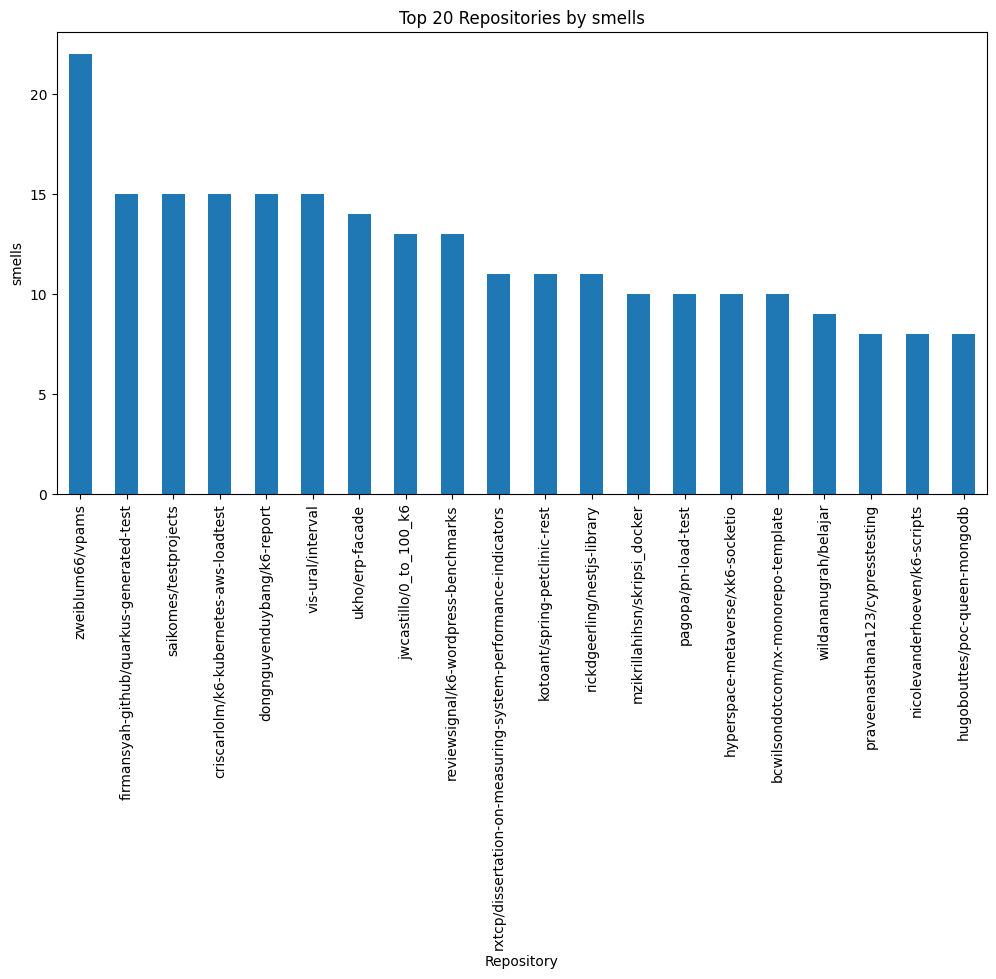

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
violations_by_repo.plot(kind='bar')
plt.title('Top 20 Repositories by smells')
plt.xlabel('Repository')
plt.ylabel('smells')
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()

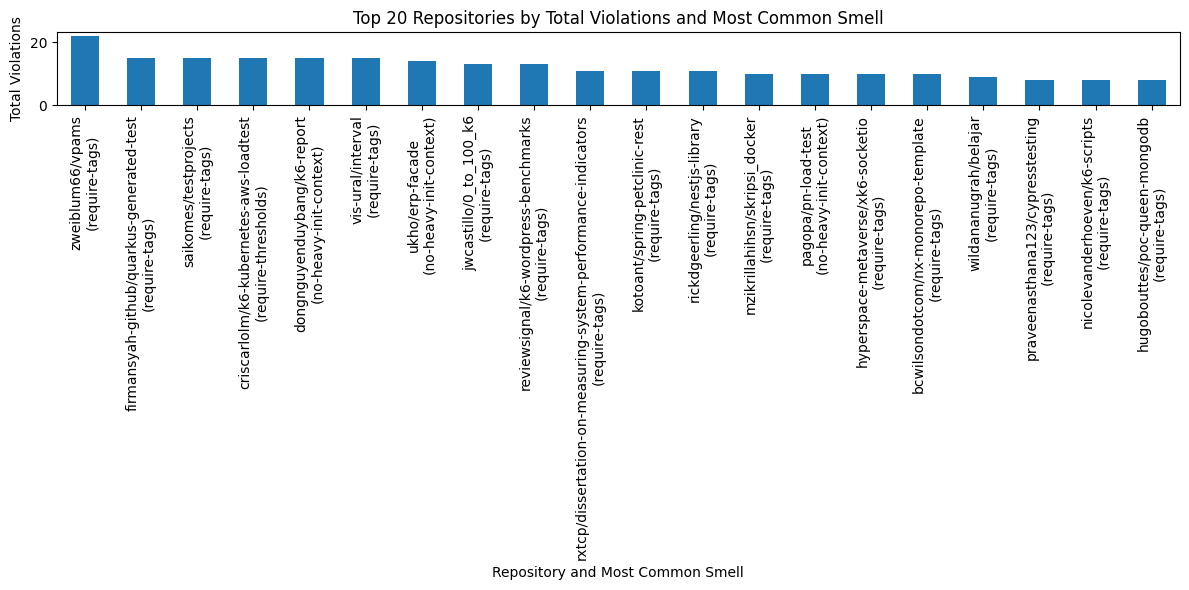

In [ ]:
def get_most_common_smell(row):
    smell_counts = row[violation_cols].sort_values(ascending=False)
    for smell, count in smell_counts.items():
        if count > 0:
            return smell.replace('k6-performance/', '')
    return 'No violations'

violations_by_repo_with_smell = df.groupby('repositório').apply(lambda x: pd.Series({
    'total_violations': x['total_violations'].sum(),
    'most_common_smell': get_most_common_smell(x.iloc[0]) # Assuming the most common smell is consistent across files in the same repo for simplicity
}), include_groups=False).sort_values(by='total_violations', ascending=False).head(20)

plt.figure(figsize=(12, 6))
violations_by_repo_with_smell['total_violations'].plot(kind='bar')
plt.title('Top 20 Repositories by Total Violations and Most Common Smell')
plt.xlabel('Repository and Most Common Smell')
plt.ylabel('Total Violations')
plt.xticks(rotation=90)

# Update x-axis labels to include the most common smell
plt.gca().set_xticklabels([f"{repo}\n({smell})" for repo, smell in zip(violations_by_repo_with_smell.index, violations_by_repo_with_smell['most_common_smell'])])

plt.tight_layout()
plt.show()

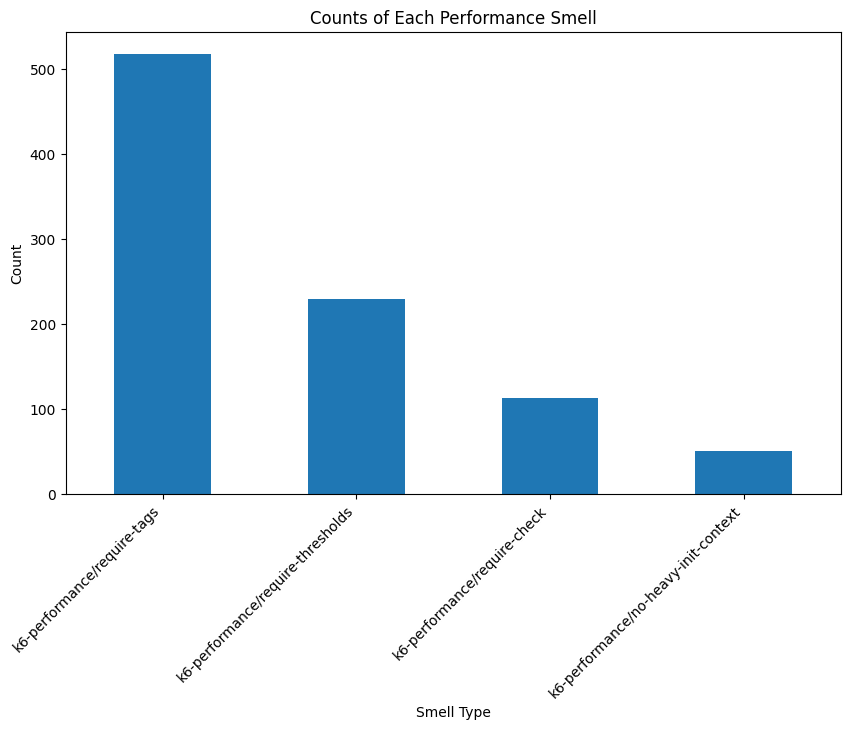

In [ ]:
smell_counts = df[violation_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
smell_counts.plot(kind='bar')
plt.title('Counts of Each Performance Smell')
plt.xlabel('Smell Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
plt.show()

In [ ]:
# Combine the two series into a DataFrame for plotting
# smell_comparison_df = pd.DataFrame({
#     'total_occurrences': smell_counts,
#     'num_repositories': smell_repo_counts_series
# })

# plt.figure(figsize=(10, 8))
# plt.scatter(smell_comparison_df['total_occurrences'], smell_comparison_df['num_repositories'])

# # Add labels for each point
# for i, smell in enumerate(smell_comparison_df.index):
#     plt.annotate(smell.replace('k6-performance/', ''), (smell_comparison_df['total_occurrences'].iloc[i], smell_comparison_df['num_repositories'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')

# plt.title('Smell Occurrences vs. Number of Repositories')
# plt.xlabel('Total Occurrences')
# plt.ylabel('Number of Repositories')
# plt.grid(True)
# plt.show()

In [ ]:
# Combine the two series into a DataFrame for plotting
# smell_comparison_df = pd.DataFrame({
#     'total_occurrences': smell_counts,
#     'num_repositories': smell_repo_counts_series
# })

# plt.figure(figsize=(10, 8))
# plt.scatter(smell_comparison_df['total_occurrences'], smell_comparison_df['num_repositories'])

# # Add labels for each point
# for i, smell in enumerate(smell_comparison_df.index):
#     plt.annotate(smell.replace('k6-performance/', ''), (smell_comparison_df['total_occurrences'].iloc[i], smell_comparison_df['num_repositories'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')

# plt.title('Smell Occurrences vs. Number of Repositories')
# plt.xlabel('Total Occurrences')
# plt.ylabel('Number of Repositories')
# plt.grid(True)
# plt.show()

In [ ]:
# Count the number of repositories with each type of smell
smell_repo_counts = {}
for smell_col in violation_cols:
    # Count unique repositories where the smell count is greater than 0
    smell_repo_counts[smell_col] = df[df[smell_col] > 0]['repositório'].nunique()

smell_repo_counts_series = pd.Series(smell_repo_counts).sort_values(ascending=False)

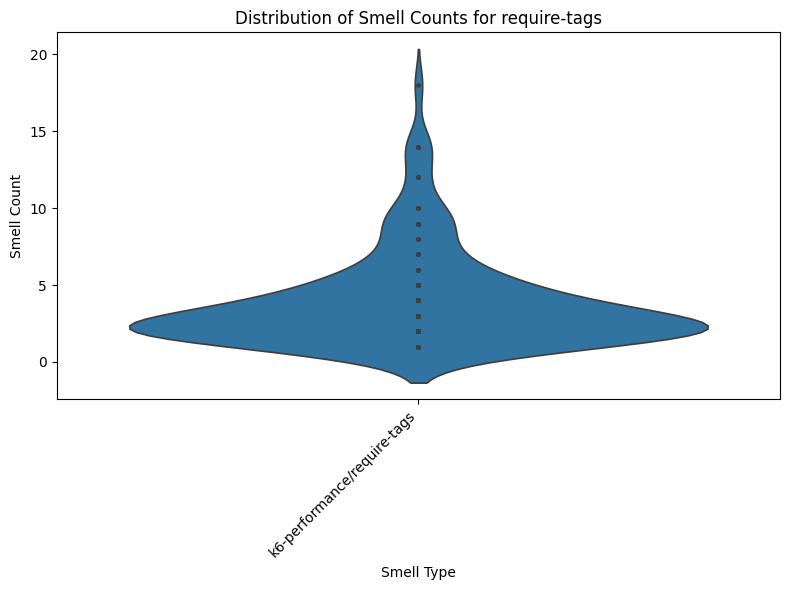

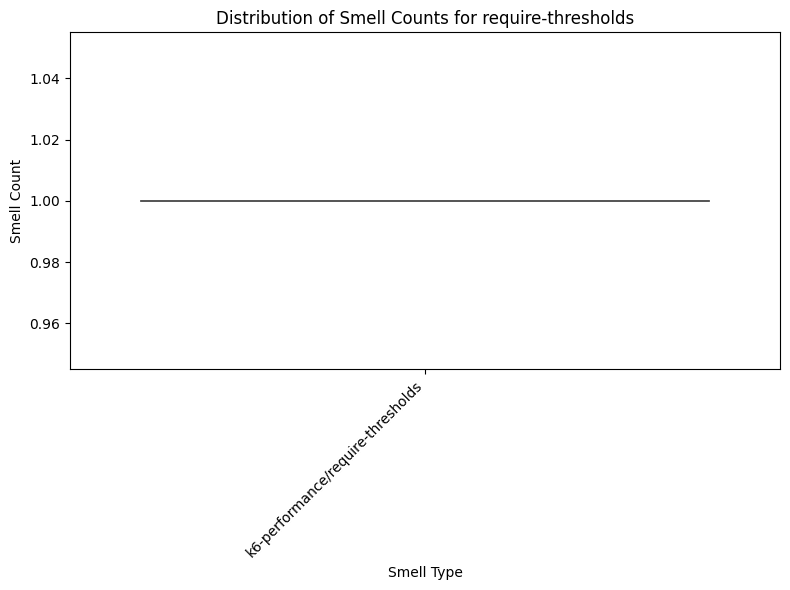

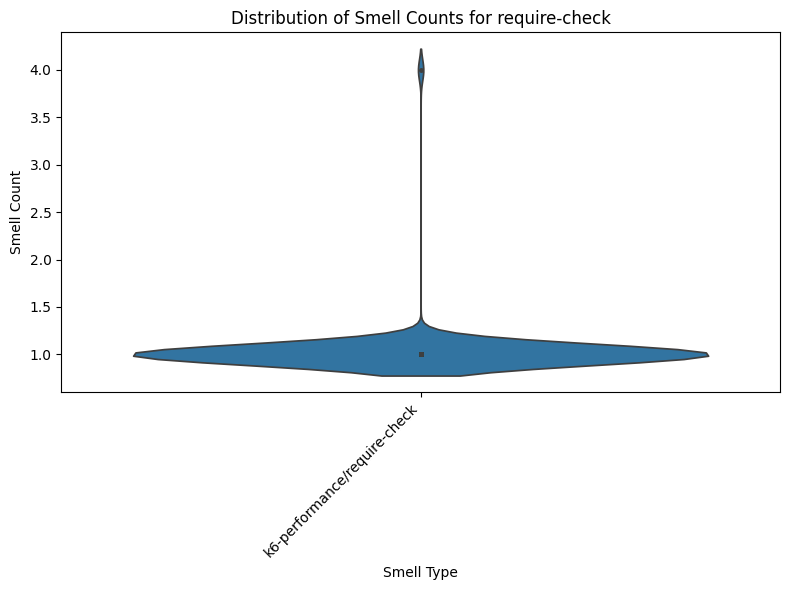

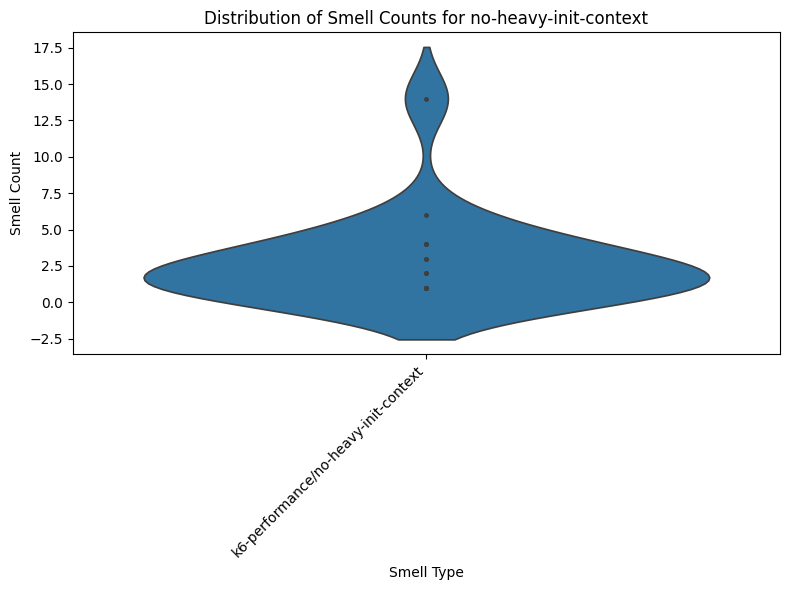

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame to long format for plotting
df_melted = df.melt(value_vars=violation_cols, var_name='Smell Type', value_name='Violation Count')

# Remove rows with zero violations for a clearer plot
df_melted = df_melted[df_melted['Violation Count'] > 0]

# Get the top 4 smells based on total occurrences
top_4_smells = smell_counts.head(4).index.tolist()

for smell_type in top_4_smells:
    df_smell = df_melted[df_melted['Smell Type'] == smell_type]

    if not df_smell.empty:
        plt.figure(figsize=(8, 6))
        sns.violinplot(x='Smell Type', y='Violation Count', data=df_smell, inner='points')
        plt.title(f'Distribution of Smell Counts for {smell_type.replace("k6-performance/", "")}')
        plt.xlabel('Smell Type')
        plt.ylabel('Smell Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No violations found for {smell_type.replace('k6-performance/', '')}")

In [ ]:
# Filter the original DataFrame to include only the top repositories with the most violations
top_repos = violations_by_repo.index
df_top_repos = df[df['repositório'].isin(top_repos)]

# Display the filtered DataFrame
display(df_top_repos)

,repositório,arquivo,k6-performance/no-heavy-init-context,k6-performance/no-heavy-init-context_loc,k6-performance/require-check,k6-performance/require-check_loc,k6-performance/require-tags,k6-performance/require-tags_loc,k6-performance/require-thresholds,k6-performance/require-thresholds_loc,total_violations
7,mzikrillahihsn/skripsi_docker,script.js,0,NaN,0,NaN,9,28:5; 37:20; 48:19; 78:22; 93:19; 104:5; 108:5...,1,10:14,10
18,vis-ural/interval,k6.js,0,NaN,0,NaN,14,17:5; 19:5; 21:5; 23:5; 25:5; 27:5; 29:5; 31:5...,1,11:14,15
87,kotoant/spring-petclinic-rest,script.js,0,NaN,0,NaN,10,146:26; 159:24; 168:26; 172:25; 175:23; 178:25...,1,5:14,11
90,nicolevanderhoeven/k6-scripts,expoqa/browser.js,0,NaN,0,NaN,8,22:5; 33:5; 51:5; 63:5; 82:5; 93:5; 104:5; 121:5,0,NaN,8
109,rxtcp/dissertation-on-measuring-system-perform...,script.js,0,NaN,0,NaN,10,146:26; 159:24; 168:26; 172:25; 175:23; 178:25...,1,5:14,11
122,praveenasthana123/cypresstesting,perf/k6-smoke.js,0,NaN,0,NaN,4,209:25; 255:32; 286:32; 312:26,0,NaN,4
123,praveenasthana123/cypresstesting,perf/k6-stress.js,0,NaN,0,NaN,4,99:23; 109:25; 122:7; 126:7,0,NaN,4
134,pagopa/pn-load-test,src/interoptracing.js,3,8:22; 8:33; 22:21,0,NaN,2,90:11; 94:25,1,8:12,6
135,pagopa/pn-load-test,src/deliverygetnotificationweb.js,3,8:22; 8:33; 15:15,0,NaN,0,NaN,1,8:12,4
140,criscarlolm/k6-kubernetes-aws-loadtest,eks/js/tcm-6440-aws.js,0,NaN,0,NaN,0,NaN,1,5:12,1


In [ ]:
# Function to identify outliers using IQR
def identify_outliers(df, smell_col):
    Q1 = df[smell_col].quantile(0.25)
    Q3 = df[smell_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[smell_col] < lower_bound) | (df[smell_col] > upper_bound)]
    return outliers[['repositório', 'arquivo', smell_col]].rename(columns={smell_col: 'violation_count'})

# Identify and display outliers for each smell type in df_top_repos
for smell_col in violation_cols:
    outliers_df = identify_outliers(df_top_repos[df_top_repos[smell_col] > 0], smell_col) # Only consider rows with violations for outlier detection
    if not outliers_df.empty:
        print(f"Outliers for {smell_col.replace('k6-performance/', '')}:")
        display(outliers_df)
    else:
        print(f"No outliers found for {smell_col.replace('k6-performance/', '')}")

Outliers for no-heavy-init-context:


,repositório,arquivo,violation_count
295,ukho/erp-facade,performance script/scripts/s100/s100webhookloa...,14


No outliers found for require-check
Outliers for require-tags:


,repositório,arquivo,violation_count
134,pagopa/pn-load-test,src/interoptracing.js,2
230,zweiblum66/vpams,benchmarks/scenarios/concurrent-users.js,18


No outliers found for require-thresholds
